# Activity Recognition system based on Multisensor data fusion 

Data Set Information:

This dataset represents a real-life benchmark in the area of Activity Recognition applications, as described in [1].

The classification tasks consist in predicting the activity performed by the user from time-series generated by a Wireless Sensor Network (WSN), according to the EvAAL competition technical annex ([Web Link]).

In our activity recognition system we use information coming the implicit alteration of the wireless channel due to the movements of the user. The devices measure the RSS of the beacon packets they exchange among themselves in the WSN [2].

We collect RSS data using IRIS nodes embedding a Chipcon AT86RF230 radio subsystem that implements the IEEE 802.15.4 standard and programmed with a TinyOS firmware. They are placed on the userâ€™s chest and ankles. For the purpose of communications, the beacon packets are exchanged by using a simple virtual token protocol that completes its execution in a time slot of 50 milliseconds. A modified version of the Spin ([Web Link]) token-passing protocol is used to schedule node transmission, in order to prevent packet collisions and maintain high data collection rate. When an anchor is transmitting, all other anchors receive the packet and perform the RSS measurements. The payload of the transmitting packet is the set of RSS values between the transmitting node and the other sensors sampled during the previous cycle.

From the raw data we extract time-domain features to compress the time series and slightly remove noise and correlations.

We choose an epoch time of 250 milliseconds according to the EVAAL technical annex. In such a time slot we elaborate 5 samples of RSS (sampled at 20 Hz) for each of the three couples of WSN nodes (i.e. Chest-Right Ankle, Chest-Left Ankle, Right Ankle-Left Ankle). The features include the mean value and standard deviation for each reciprocal RSS reading from worn WSN sensors.

For each activity 15 temporal sequences of input RSS data are present. The dataset contains 480 sequences, for a total number of 42240 instances.

We also consider two kind of bending activity, illustrated in the figure provided (bendingTupe.pdf). The positions of sensor nodes with the related identifiers are shown in figure sensorsPlacement.pdf.

### Import Packages

In [1]:
import requests
import zipfile, os
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
sns.set()

### Downloading the data and Unziping 


In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00366/AReM.zip'
r = requests.get(url)
with open("data.zip", "wb") as code:
    code.write(r.content)

In [3]:
# Unziping the data (Restart the Kernel if ERROR is shown)

FolderName = 'DataFolder'
ParentFolderPath = os.getcwd()
DataFolderPath = ParentFolderPath +'/'+ FolderName

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(ParentFolderPath+'/'+FolderName)

In [4]:
# Change the current working directory
os.chdir(DataFolderPath)

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /Users/soamm/Soam/FS DS/ML/ML Live Class /2-Logistic Regression/Class-HomeWork-ActivityRecognition/DataFolder


### Remove The PDF Files before automating the extraction

In [5]:
# Remove the PDF files 
try:
    os.remove('sensorsPlacement.pdf') 
    os.remove('bendingType.pdf') 
except:    
    print('Files already deleted/Not present')

### Setup the Master DataFrame on which EDA and model building will be perfomed

In [6]:
# Setup the Master DataFrame

Features = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13','avg_rss23', 'var_rss23', 'Label']

df = pd.DataFrame(columns=Features)
df

Empty DataFrame
Columns: [# Columns: time, avg_rss12, var_rss12, avg_rss13, var_rss13, avg_rss23, var_rss23, Label]
Index: []

### Fixing bending2 - Dataset4. (Its not comma separated). Before extracting the other dataset

In [7]:
path = DataFolderPath+'/bending2/dataset4.csv'
Features = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13','avg_rss23', 'var_rss23', 'Label']
unorgDf = pd.DataFrame(columns=Features)
unorgDf = pd.read_csv(path ,skiprows=5,delimiter=r"\s+",names=Features)
unorgDf['Label'] = 'bending2'

# Append to master dataframe
df = df.append(unorgDf, ignore_index=True)
df


# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                 0      32.50       0.50       0.00       0.00      19.00   
1               250      32.50       0.50       0.00       0.00      18.50   
2               500      32.75       0.43       1.00       0.00      18.00   
3               750      32.50       0.50       0.00       0.00      17.50   
4              1000      32.50       0.50       7.50       0.50      17.50   
..              ...        ...        ...        ...        ...        ...   
475          118750      28.67       0.47       4.67       1.25      17.33   
476          119000      27.50       0.50       5.50       2.50      17.25   
477          119250      28.00       0.00       6.67       0.94      17.00   
478          119500      28.00       0.00       5.00       0.82      17.00   
479          119750      28.00       0.00       0.00       0.00      17.00   

     var_rss23     Label  
0         1.00  bending2  
1         0.50  bending2  
2         0.00  bending2  
3         0.50  bending2  
4         0.87  bending2  
..         ...       ...  
475       0.47  bending2  
476       1.30  bending2  
477       1.00  bending2  
478       0.71  bending2  
479       1.00  bending2  

[480 rows x 8 columns]

In [8]:
# Delete the bending2 - Dataset4(unorganised csv) file after performing operation
try:
    os.remove(path) 
except:    
    print('Files already deleted/Not present')

## Automation: Extracting all the dataset 

In [9]:
# Extract all the data and move it to MasterDataframe in correct format
os.chdir(DataFolderPath)

Folders = os.listdir()

if '.DS_Store' in Folders:
        Folders.remove('.DS_Store')

print('Folders to be analyzed: ',Folders)

for folder in Folders:
    os.chdir(DataFolderPath+'/'+folder)
    
    CSV_Files = os.listdir()
    if '.DS_Store' in CSV_Files:
        CSV_Files.remove('.DS_Store')
        
    for csvfile in CSV_Files:
        df_temp = pd.read_csv(csvfile, skiprows=4,error_bad_lines=False)
        df_temp['Label'] = os.path.basename(os.getcwd())
        df = df.append(df_temp, ignore_index=True)
    print('All csv files of ',folder, 'is appended')
    
    os.chdir(DataFolderPath)   

Folders to be analyzed:  ['bending1', 'walking', 'bending2', 'standing', 'sitting', 'lying', 'cycling']
All csv files of  bending1 is appended
All csv files of  walking is appended
All csv files of  bending2 is appended
All csv files of  standing is appended
All csv files of  sitting is appended
All csv files of  lying is appended
All csv files of  cycling is appended


b'Skipping line 485: expected 7 fields, saw 8\n'
b'Skipping line 485: expected 7 fields, saw 8\n'


In [10]:
# Print the resultant dataframe
df

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                   0      32.50       0.50       0.00       0.00      19.00   
1                 250      32.50       0.50       0.00       0.00      18.50   
2                 500      32.75       0.43       1.00       0.00      18.00   
3                 750      32.50       0.50       0.00       0.00      17.50   
4                1000      32.50       0.50       7.50       0.50      17.50   
...               ...        ...        ...        ...        ...        ...   
42232          118500      40.25       1.30      12.67       1.70      20.50   
42233          118750      41.75       1.79      11.00       6.00      16.67   
42234          119000      36.33       0.47      16.00       3.16      20.33   
42235          119250      31.50       1.50      21.00       0.00      12.25   
42236          119500      34.25       6.38      12.67       2.49      15.25   

       var_rss23     Label  
0           1.00  bending2  
1           0.50  bending2  
2           0.00  bending2  
3           0.50  bending2  
4           0.87  bending2  
...          ...       ...  
42232       0.50   cycling  
42233       2.49   cycling  
42234       1.70   cycling  
42235       7.12   cycling  
42236       4.21   cycling  

[42237 rows x 8 columns]

### Create the New CSV file containing clean data

In [11]:
os.chdir(ParentFolderPath)
df.to_csv('MasterDataSet.csv',index=False)

In [12]:
data = pd.read_csv('MasterDataSet.csv')
data

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      32.50       0.50       0.00       0.00      19.00   
1                  250      32.50       0.50       0.00       0.00      18.50   
2                  500      32.75       0.43       1.00       0.00      18.00   
3                  750      32.50       0.50       0.00       0.00      17.50   
4                 1000      32.50       0.50       7.50       0.50      17.50   
...                ...        ...        ...        ...        ...        ...   
42232           118500      40.25       1.30      12.67       1.70      20.50   
42233           118750      41.75       1.79      11.00       6.00      16.67   
42234           119000      36.33       0.47      16.00       3.16      20.33   
42235           119250      31.50       1.50      21.00       0.00      12.25   
42236           119500      34.25       6.38      12.67       2.49      15.25   

       var_rss23     Label  
0           1.00  bending2  
1           0.50  bending2  
2           0.00  bending2  
3           0.50  bending2  
4           0.87  bending2  
...          ...       ...  
42232       0.50   cycling  
42233       2.49   cycling  
42234       1.70   cycling  
42235       7.12   cycling  
42236       4.21   cycling  

[42237 rows x 8 columns]

### EDA

In [13]:
data.describe()

# Columns: time     avg_rss12     var_rss12     avg_rss13  \
count     42237.000000  42237.000000  42237.000000  42237.000000   
mean      59873.262779     38.917394      1.459142     14.277895   
std       34639.395990      6.337385      2.048017      5.435382   
min           0.000000      0.000000      0.000000      0.000000   
25%       30000.000000     35.000000      0.400000     11.330000   
50%       59750.000000     39.750000      0.500000     15.000000   
75%       89750.000000     43.750000      1.790000     18.000000   
max      119750.000000     56.250000     17.240000     35.000000   

          var_rss13     avg_rss23     var_rss23  
count  42237.000000  42237.000000  42237.000000  
mean       1.502218     16.034921      1.620690  
std        1.639554      6.736081      1.637101  
min        0.000000      0.000000      0.000000  
25%        0.430000     12.000000      0.470000  
50%        0.830000     16.000000      1.000000  
75%        2.290000     19.250000      2.290000  
max       11.420000     40.330000     13.610000

In [14]:
data.shape

(42237, 8)

In [15]:
# Print the Unique Label
data['Label'].unique()

array(['bending2', 'bending1', 'walking', 'standing', 'sitting', 'lying',
       'cycling'], dtype=object)

In [16]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Label'])

data

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                    0      32.50       0.50       0.00       0.00      19.00   
1                  250      32.50       0.50       0.00       0.00      18.50   
2                  500      32.75       0.43       1.00       0.00      18.00   
3                  750      32.50       0.50       0.00       0.00      17.50   
4                 1000      32.50       0.50       7.50       0.50      17.50   
...                ...        ...        ...        ...        ...        ...   
42232           118500      40.25       1.30      12.67       1.70      20.50   
42233           118750      41.75       1.79      11.00       6.00      16.67   
42234           119000      36.33       0.47      16.00       3.16      20.33   
42235           119250      31.50       1.50      21.00       0.00      12.25   
42236           119500      34.25       6.38      12.67       2.49      15.25   

       var_rss23  Label  
0           1.00      1  
1           0.50      1  
2           0.00      1  
3           0.50      1  
4           0.87      1  
...          ...    ...  
42232       0.50      2  
42233       2.49      2  
42234       1.70      2  
42235       7.12      2  
42236       4.21      2  

[42237 rows x 8 columns]

In [93]:
data['Label'].unique()

array([1, 0, 6, 5, 4, 3, 2])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42237 entries, 0 to 42236
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   # Columns: time  42237 non-null  int64  
 1   avg_rss12        42237 non-null  float64
 2   var_rss12        42237 non-null  float64
 3   avg_rss13        42237 non-null  float64
 4   var_rss13        42237 non-null  float64
 5   avg_rss23        42237 non-null  float64
 6   var_rss23        42237 non-null  float64
 7   Label            42237 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 2.6 MB


In [18]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

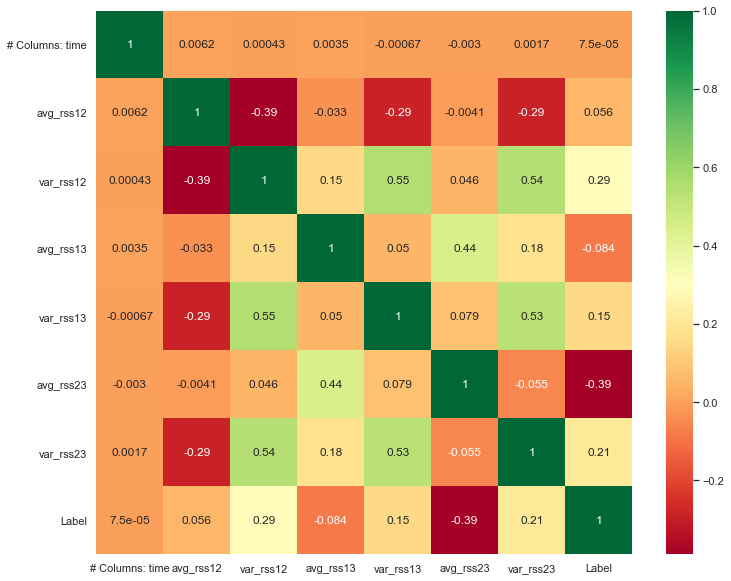

In [19]:
plt.figure(figsize=(12,10))  
p=sns.heatmap(data.corr(), annot=True,cmap ='RdYlGn')

In [20]:
data.isnull().sum()

# Columns: time    0
avg_rss12          0
var_rss12          0
avg_rss13          0
var_rss13          0
avg_rss23          0
var_rss23          0
Label              0
dtype: int64

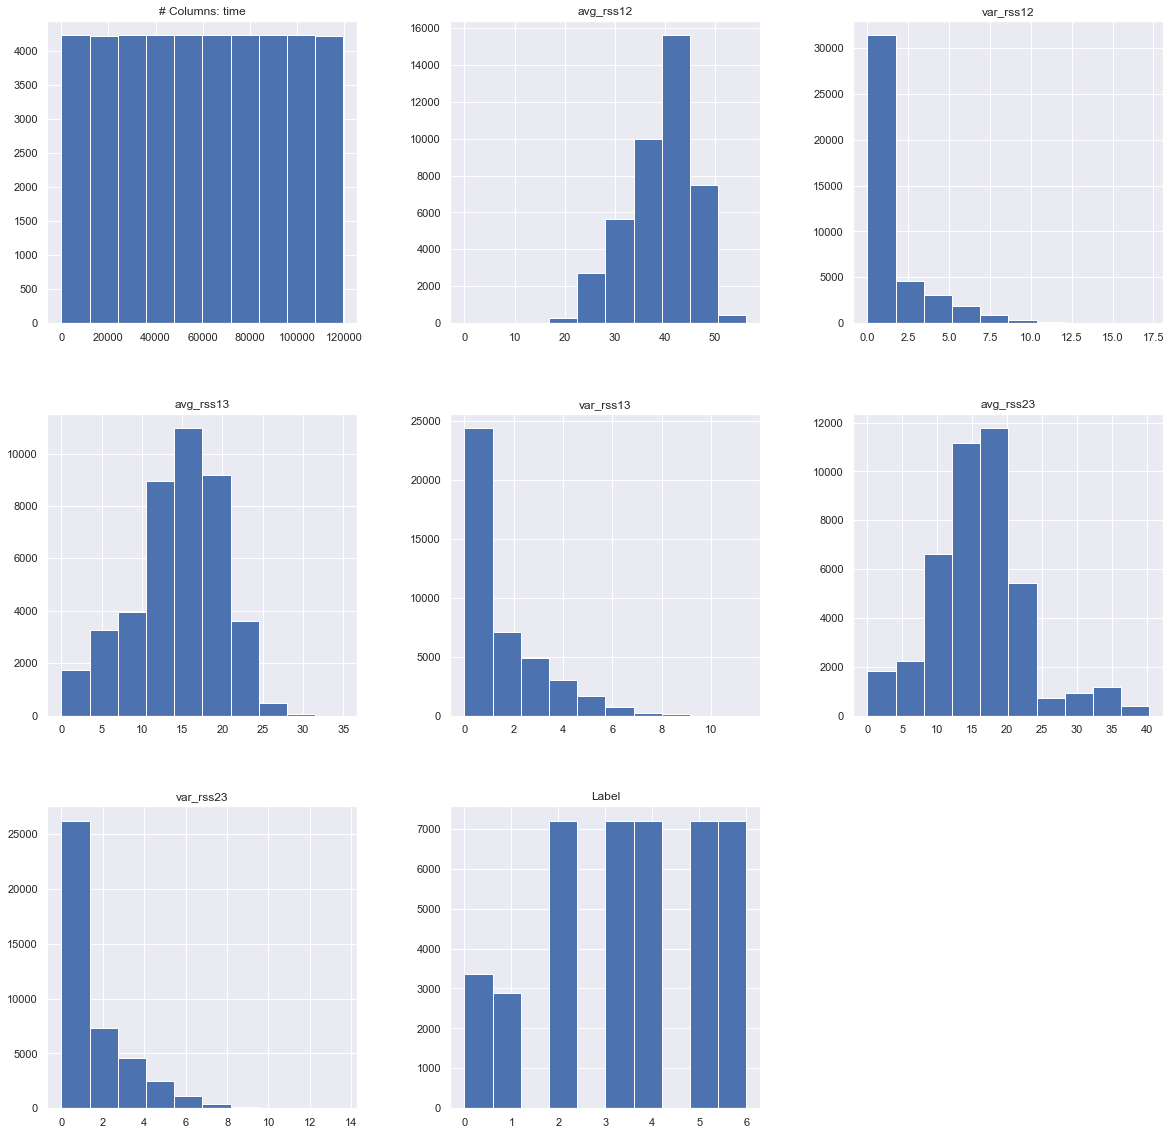

In [21]:
p = data.hist(figsize = (20,20))

### Outlier Check

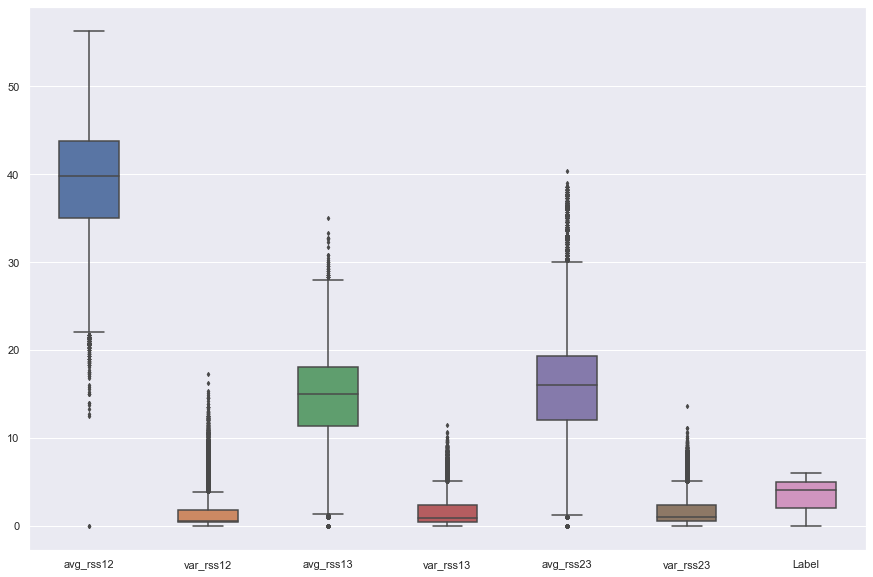

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data.iloc[:,1:], width= 0.5,ax=ax,  fliersize=3)

In [23]:
# Removing the Outliers

q = data['avg_rss12'].quantile(0.90)
data = data[data['avg_rss12']<q]

q = data['var_rss13'].quantile(0.90)
data = data[data['var_rss13']<q]

q = data['var_rss12'].quantile(0.60)
data = data[data['var_rss12']<q]

q = data['var_rss12'].quantile(0.80)
data = data[data['var_rss12']<q]

q = data['var_rss23'].quantile(0.70)
data = data[data['var_rss23']<q]

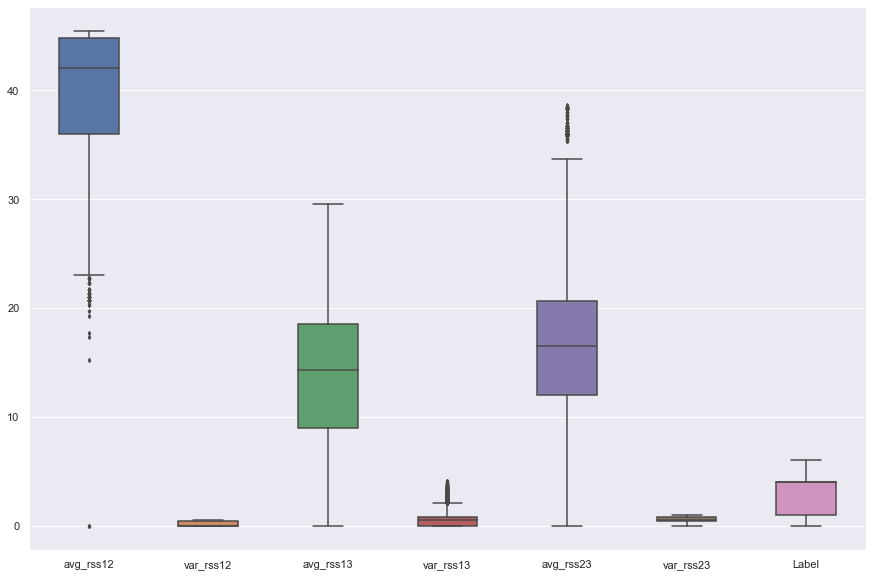

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=data.iloc[:,1:], width= 0.5,ax=ax,  fliersize=3)

In [25]:
data.corr()

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  \
# Columns: time         1.000000   0.014345   0.045026   0.025759  -0.000624   
avg_rss12               0.014345   1.000000   0.029834   0.217830  -0.009619   
var_rss12               0.045026   0.029834   1.000000  -0.124949   0.043596   
avg_rss13               0.025759   0.217830  -0.124949   1.000000  -0.148169   
var_rss13              -0.000624  -0.009619   0.043596  -0.148169   1.000000   
avg_rss23              -0.001290   0.169369  -0.047696   0.481390   0.071581   
var_rss23               0.032829  -0.011098  -0.014089  -0.007285   0.037124   
Label                  -0.015624   0.359280  -0.064169  -0.111696  -0.077140   

                 avg_rss23  var_rss23     Label  
# Columns: time  -0.001290   0.032829 -0.015624  
avg_rss12         0.169369  -0.011098  0.359280  
var_rss12        -0.047696  -0.014089 -0.064169  
avg_rss13         0.481390  -0.007285 -0.111696  
var_rss13         0.071581   0.037124 -0.077140  
avg_rss23         1.000000  -0.113575 -0.529026  
var_rss23        -0.113575   1.000000  0.153337  
Label            -0.529026   0.153337  1.000000

In [26]:
data.isnull().sum()

# Columns: time    0
avg_rss12          0
var_rss12          0
avg_rss13          0
var_rss13          0
avg_rss23          0
var_rss23          0
Label              0
dtype: int64

### Model Building

In [53]:
X = data.drop(['Label','# Columns: time'],axis=1)
Y = data['Label']

In [54]:
X

avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23
2          32.75       0.43       1.00       0.00      18.00       0.00
5          32.67       0.47      11.00       1.00      16.75       0.83
8          32.33       0.47       6.00       0.00      18.33       0.47
9          32.67       0.47       8.00       0.82      18.00       0.00
13         32.00       0.00       2.67       0.47      15.75       0.83
...          ...        ...        ...        ...        ...        ...
41981      42.00       0.00      16.67       2.62      22.00       0.71
42099      38.67       0.47       0.00       0.00       0.00       0.00
42111      39.00       0.00      10.50       2.50      17.75       0.43
42147      44.67       0.47      11.00       3.27      22.00       0.82
42203      32.67       0.47      15.50       3.50      15.33       0.47

[9878 rows x 6 columns]

In [55]:
Y

2        1
5        1
8        1
9        1
13       1
        ..
41981    2
42099    2
42111    2
42147    2
42203    2
Name: Label, Length: 9878, dtype: int64

In [56]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [57]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]

#let's check the values
vif

Features       vif
0  avg_rss12  1.059486
1  var_rss12  1.020258
2  avg_rss13  1.420174
3  var_rss13  1.055339
4  avg_rss23  1.369361
5  var_rss23  1.019779

VIF values are less than 5, That means no multicollinearity.

### Splitting data

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=50)

### Model 1 - Solver: lbfgs

In [59]:
log_reg = LogisticRegression(solver="lbfgs")

log_reg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
Y_prediction = log_reg.predict(X_test)

In [61]:
confusion_matrix(Y_test,Y_prediction)

array([[201,   3,   0,   0,  45,   4,   0],
       [ 13, 229,   2,  23,  24,   0,   0],
       [  0,   1,   2,   1,   8,   0,   0],
       [  0,  16,   0, 399,   7,  22,   0],
       [ 12,  44,   1,  36, 272, 137,   0],
       [  4,   0,   0,  16, 117, 335,   0],
       [  0,   1,   0,   0,   1,   0,   0]])

In [62]:
print(classification_report(Y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       253
           1       0.78      0.79      0.78       291
           2       0.40      0.17      0.24        12
           3       0.84      0.90      0.87       444
           4       0.57      0.54      0.56       502
           5       0.67      0.71      0.69       472
           6       0.00      0.00      0.00         2

    accuracy                           0.73      1976
   macro avg       0.59      0.56      0.57      1976
weighted avg       0.72      0.73      0.72      1976



/Users/soamm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
accuracy_score(Y_test,Y_prediction)

0.7277327935222672

### Model 2 - Solver: newton-cg

In [64]:
log_reg_2 = LogisticRegression(solver="newton-cg",multi_class='ovr')

log_reg_2.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
Y_prediction = log_reg_2.predict(X_test)

In [66]:
print(classification_report(Y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       253
           1       0.74      0.76      0.75       291
           2       0.50      0.08      0.14        12
           3       0.77      0.91      0.84       444
           4       0.58      0.40      0.47       502
           5       0.63      0.74      0.68       472
           6       0.00      0.00      0.00         2

    accuracy                           0.70      1976
   macro avg       0.58      0.53      0.53      1976
weighted avg       0.69      0.70      0.69      1976



/Users/soamm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
accuracy_score(Y_test,Y_prediction)

0.7009109311740891

### Model 3 - Solver: sag

In [68]:
log_reg_3 = LogisticRegression(solver="sag",multi_class='ovr')

log_reg_3.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [69]:
Y_prediction = log_reg_3.predict(X_test)

In [70]:
print(classification_report(Y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       253
           1       0.74      0.76      0.75       291
           2       0.50      0.08      0.14        12
           3       0.77      0.91      0.84       444
           4       0.58      0.40      0.47       502
           5       0.63      0.74      0.68       472
           6       0.00      0.00      0.00         2

    accuracy                           0.70      1976
   macro avg       0.58      0.53      0.53      1976
weighted avg       0.69      0.70      0.69      1976



/Users/soamm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
accuracy_score(Y_test,Y_prediction)

0.7009109311740891

In [72]:
confusion_matrix(Y_test,Y_prediction)

array([[209,   4,   0,   0,  30,  10,   0],
       [ 16, 220,   0,  41,  14,   0,   0],
       [  0,   2,   1,   1,   8,   0,   0],
       [  0,  17,   0, 405,   7,  15,   0],
       [ 18,  52,   1,  51, 199, 181,   0],
       [ 12,   0,   0,  26,  83, 351,   0],
       [  0,   1,   0,   0,   1,   0,   0]])

### Model 4 - Solver: saga

In [73]:
log_reg_4 = LogisticRegression(solver="saga",multi_class='ovr')

log_reg_4.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
Y_prediction = log_reg_3.predict(X_test)

In [75]:
print(classification_report(Y_test, Y_prediction))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       253
           1       0.74      0.76      0.75       291
           2       0.50      0.08      0.14        12
           3       0.77      0.91      0.84       444
           4       0.58      0.40      0.47       502
           5       0.63      0.74      0.68       472
           6       0.00      0.00      0.00         2

    accuracy                           0.70      1976
   macro avg       0.58      0.53      0.53      1976
weighted avg       0.69      0.70      0.69      1976



/Users/soamm/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
accuracy_score(Y_test,Y_prediction)

0.7009109311740891

### Creating the Model file 

In [78]:
filename='modelFile.sav'
pickle.dump(log_reg,open(filename,'wb'))